# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import cv2
import glob
import matplotlib.image as mpimg

training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### 1.1 Basic Summary of the Dataset

In [3]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### 1.2 Exploratory Visualization of Dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

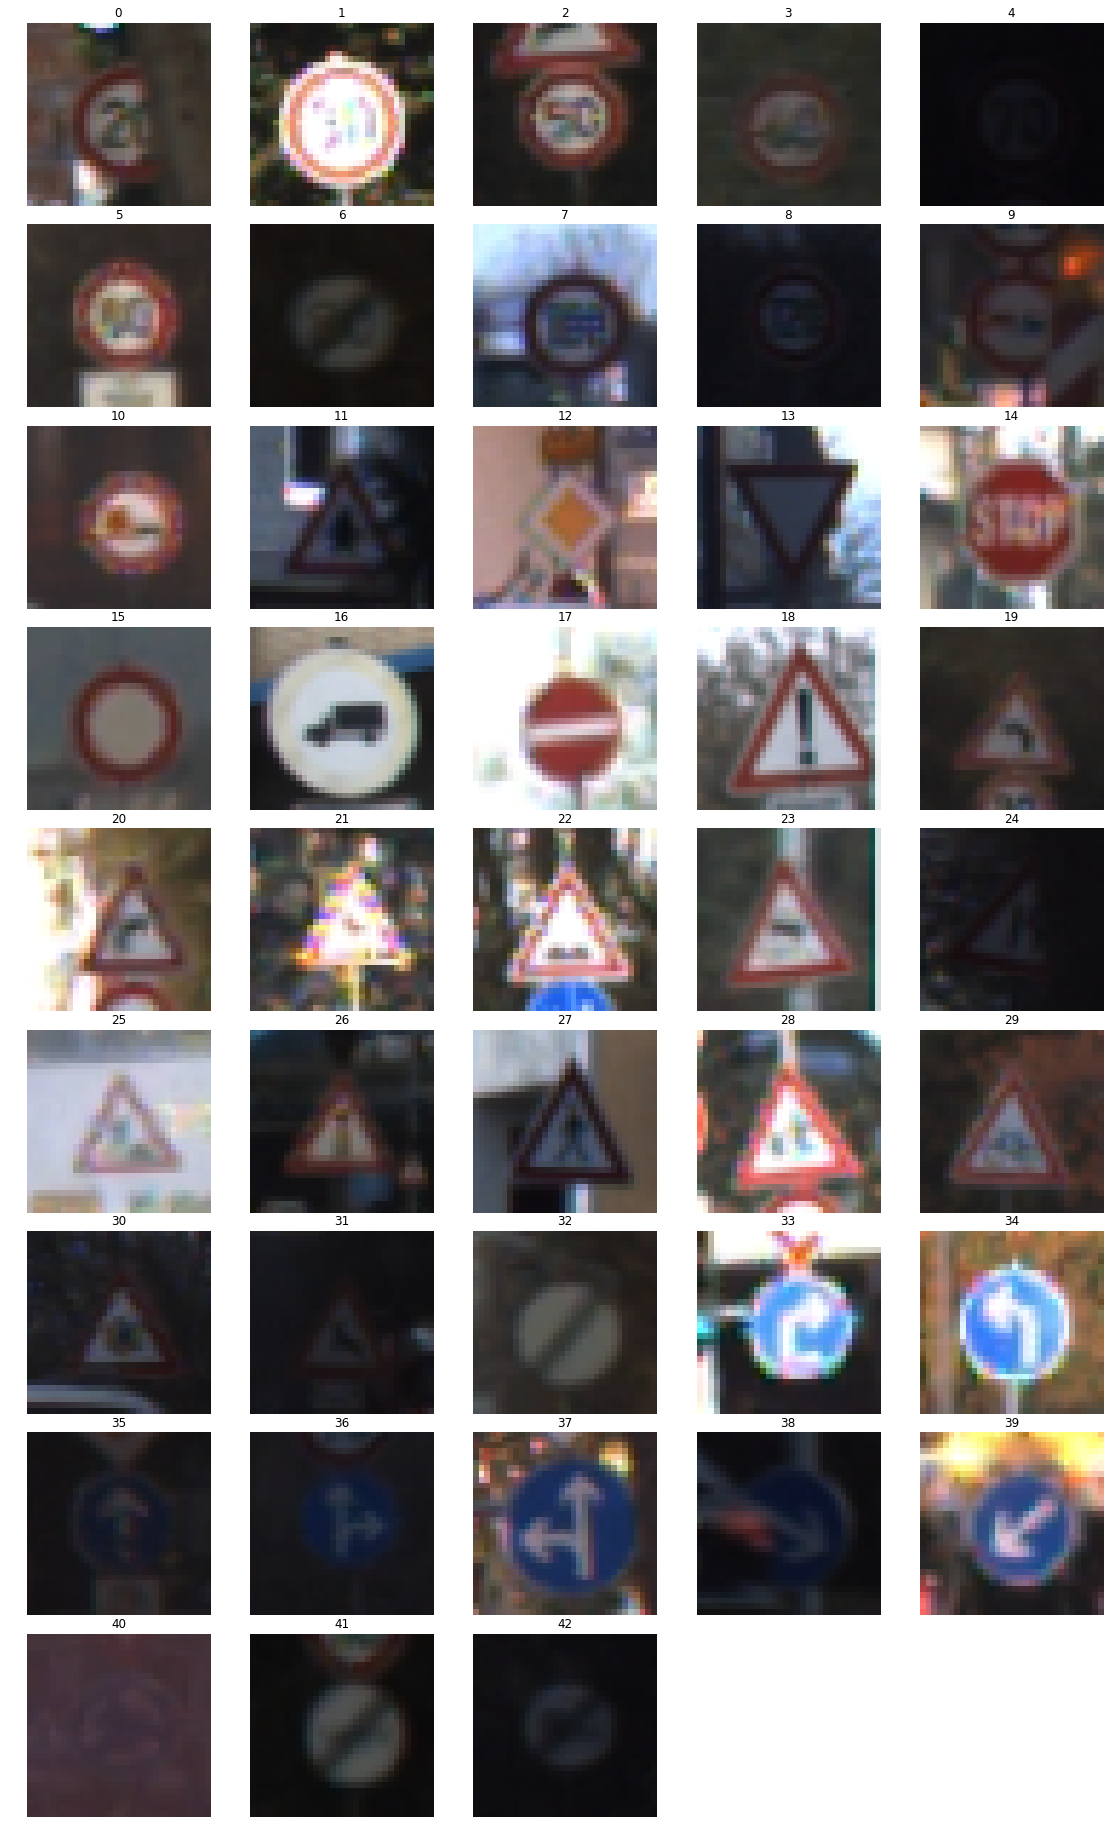

In [10]:
f, axs = plt.subplots(9, 5, figsize=(20,33))
f.subplots_adjust(hspace = .1, wspace=.001)
f.delaxes(axs[8][3])
f.delaxes(axs[8][4])
axs = axs.ravel()
index = 0
for i in range(43):
    for photo in range(len(X_valid)):
        if y_valid[photo] == index:
            axs[i].axis('off')
            axs[i].imshow(X_valid[photo])
            axs[i].set_title(y_valid[photo])
            break
    index+=1

### 1.3 Analysis of Dataset
Plot histograms of training and validation datasets for analysis.

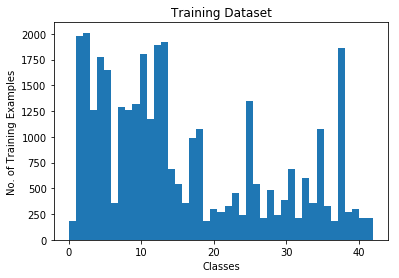

Mean number of samples per class: 809.3
Minimum number of samples per class: 180.0


In [11]:
plt.hist(y_train, bins=n_classes)
plt.ylabel("No. of Training Examples")
plt.xlabel("Classes")
plt.title("Training Dataset")
plt.show()

print("Mean number of samples per class: {:.1f}".format(np.mean(np.bincount(y_train))))
print("Minimum number of samples per class: {:.1f}".format(np.min(np.bincount(y_train))))

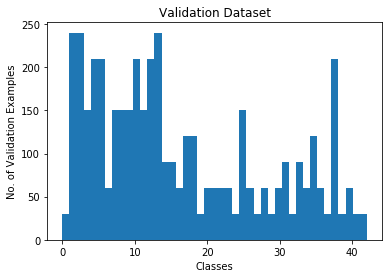

Mean number of samples per class: 102.6
Minimum number of samples per class: 30.0


In [12]:
plt.hist(y_valid, bins=n_classes)
plt.ylabel("No. of Validation Examples")
plt.xlabel("Classes")
plt.title("Validation Dataset")
plt.show()

print("Mean number of samples per class: {:.1f}".format(np.mean(np.bincount(y_valid))))
print("Minimum number of samples per class: {:.1f}".format(np.min(np.bincount(y_valid))))

**Analysis**:
The training dataset looks very unbalanced, with some classes having about 180 examples only, while others having more than 2,000 examples. If trained using this dataset, there might be biasedness or overfitting to the classes with large number of examples.

From Pierre Sermanet and Yann LeCun's paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks", it was stated that *"ConvNets architectures have built-in invariance to small translations, scaling and rotations. When a dataset does not naturally contain those deformations, adding them synthetically will yield more robust learning to potential deformations in the test set. Other realistic perturbations would probably also increase robustness such as other affine transformations, brightness, contrast and blur."*

To avoid the biasedness or overfitting problem, we can build a jittered dataset by synthetically adding transformed versions of the original training and validation sets, such as:
- Small translations
- Scaling
- Rotations
- Altered brightness

### 1.4 Function Defintions for Dataset Augmentation

#### 1.4.1 Augmentation: Random Translation
Translate the image randomly, to a maximum of 2 pixels, in the x and y directions. The direction of translation can be deduced by observing the sides with black borders, if the translation is large enough to be perceivable.

(32, 32, 3)


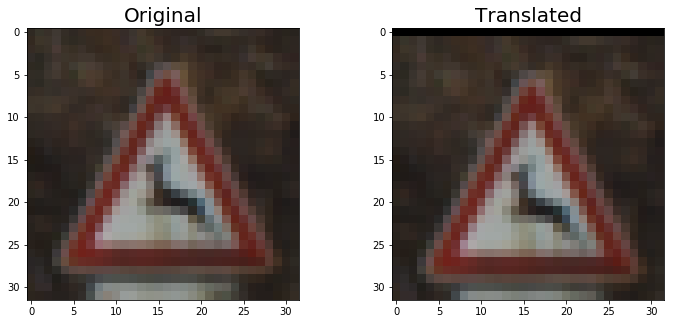

In [17]:
def translate(img):
    
    # Allow maximum translation of +/- 2 pixels
    dx = np.random.randint(-2,2)
    dy = np.random.randint(-2,2)
    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(32,32))
    return dst

print((translate(X_train[888])).shape)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.imshow(X_train[888])
ax1.set_title("Original", fontsize=20)
ax2.imshow(translate(X_train[888]))
ax2.set_title("Translated", fontsize=20)
plt.show()

#### 1.4.2 Augmentation: Random Scaling
Use the openCV getPerspectiveTransform() function to scale a square of the original image to the new image.

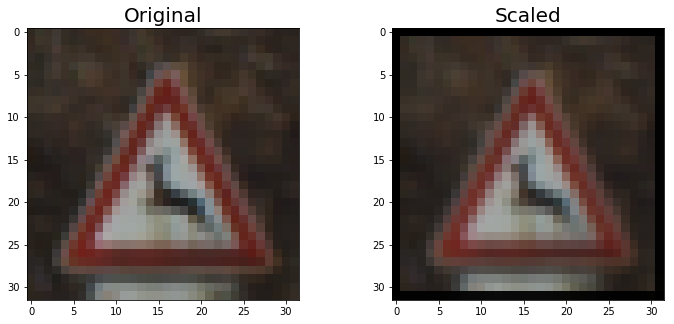

In [18]:
def scale(img):
    
    # Allow maximum transform limit of 2 pixels
    px = np.random.randint(-2,2)
    
    # 4 corners of original image
    pts_original = np.float32([[px,px],[32-px,px],[px,32-px],[32-px,32-px]])
    
    # New image
    pts_new = np.float32([[0,0],[32,0],[0,32],[32,32]])   
    
    M = cv2.getPerspectiveTransform(pts_original, pts_new)
    
    dst = cv2.warpPerspective(img, M, (32,32))
    
    return dst

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.imshow(X_train[888])
ax1.set_title("Original", fontsize=20)
ax2.imshow(scale(X_train[888]))
ax2.set_title("Scaled", fontsize=20)
plt.show()

#### 1.4.3 Augmentation: Random Rotation

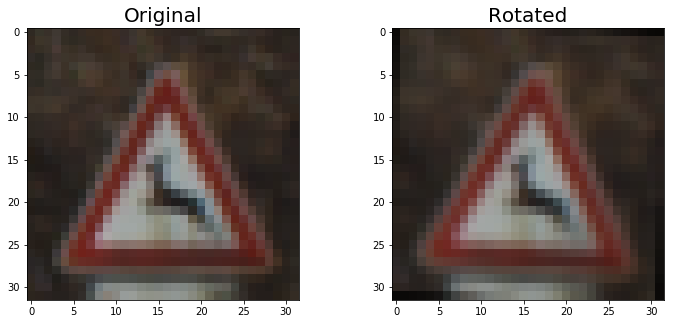

In [19]:
def rotate(img):
    
    deg = np.random.randint(-3,3)
    M = cv2.getRotationMatrix2D(((32-1)/2.0,(32-1)/2.0),deg,1)
    dst = cv2.warpAffine(img,M,(32,32))
    return dst

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.imshow(X_train[888])
ax1.set_title("Original", fontsize=20)
ax2.imshow(rotate(X_train[888]))
ax2.set_title("Rotated", fontsize=20)
plt.show()

#### 1.4.4 Augmentation: Combined Random Translation, Scaling and Rotation
Visualize a series of augmented series.

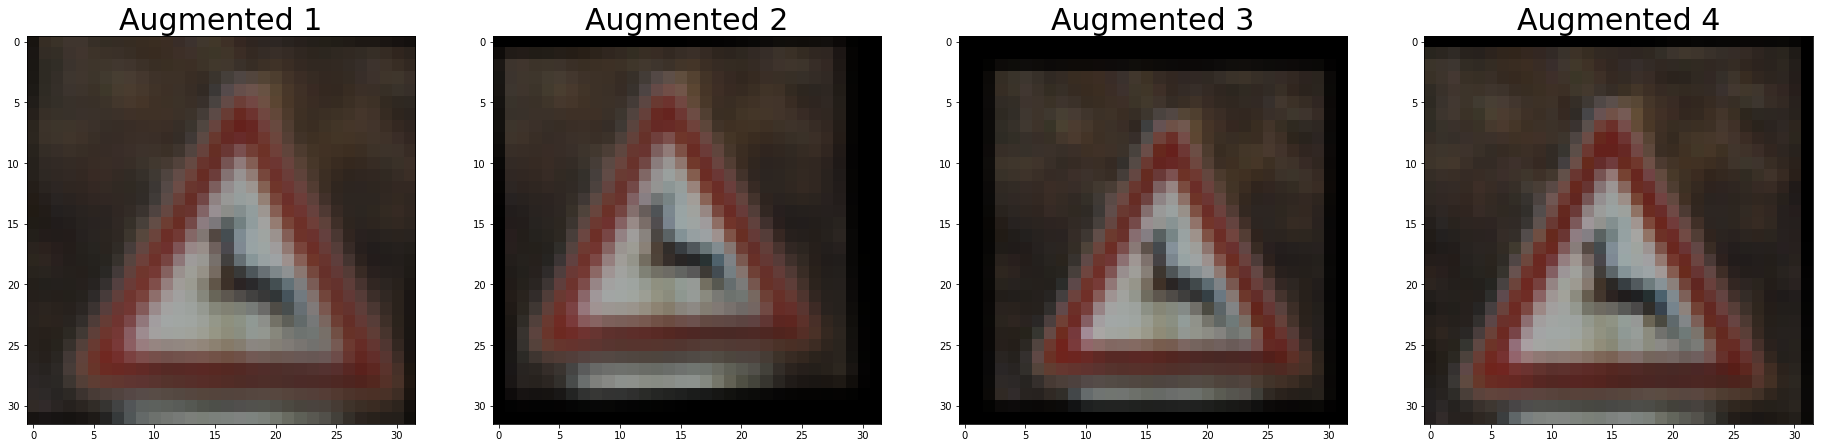

In [22]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(32,32))
ax1.imshow(rotate(scale(translate(X_train[888]))))
ax1.set_title("Augmented 1", fontsize=30)
ax2.imshow(rotate(scale(translate(X_train[888]))))
ax2.set_title("Augmented 2", fontsize=30)
ax3.imshow(rotate(scale(translate(X_train[888]))))
ax3.set_title("Augmented 3", fontsize=30)
ax4.imshow(rotate(scale(translate(X_train[888]))))
ax4.set_title("Augmented 4", fontsize=30)
plt.show()

### 1.5 Augmenting the Dataset


#### 1.5.1 Augment Training Dataset
Add randomly translated, rotated, and scaled images to each class in the training dataset, IF the number of training examples of that class < 800. 800 is the mean number of samples per class for the training dataset.

**THIS FUNCTION TAKES A LONG TIME TO RUN.**

In [11]:
for label in range(n_classes):
    label_indices = np.where(y_train == label)
    n_samples = len(label_indices[0])
    print("Working on class {:.1f}".format(label+1))
    if n_samples < 800:
        for i in range(800 - n_samples):
            new_img = X_train[label_indices[0][i%n_samples]]
            new_img = translate(scale(rotate(new_img)))
            X_train = np.concatenate((X_train, [new_img]))
            y_train = np.concatenate((y_train,[label]))
            
print(X_train.shape)

Working on class 1.0
Working on class 2.0
Working on class 3.0
Working on class 4.0
Working on class 5.0
Working on class 6.0
Working on class 7.0
Working on class 8.0
Working on class 9.0
Working on class 10.0
Working on class 11.0
Working on class 12.0
Working on class 13.0
Working on class 14.0
Working on class 15.0
Working on class 16.0
Working on class 17.0
Working on class 18.0
Working on class 19.0
Working on class 20.0
Working on class 21.0
Working on class 22.0
Working on class 23.0
Working on class 24.0
Working on class 25.0
Working on class 26.0
Working on class 27.0
Working on class 28.0
Working on class 29.0
Working on class 30.0
Working on class 31.0
Working on class 32.0
Working on class 33.0
Working on class 34.0
Working on class 35.0
Working on class 36.0
Working on class 37.0
Working on class 38.0
Working on class 39.0
Working on class 40.0
Working on class 41.0
Working on class 42.0
Working on class 43.0
(46480, 32, 32, 3)


#### 1.5.2 Augment Validation Dataset
Add randomly translated, rotated, and scaled images to each class in the validation dataset, IF the number of training examples of that class < 100. 100 is the mean number of samples per class for the validation dataset.

In [12]:
for label in range(n_classes):
    label_indices = np.where(y_valid == label)
    n_samples = len(label_indices[0])
    print("Working on class {:.1f}".format(label+1))
    if n_samples < 100:
        for i in range(100 - n_samples):
            new_img = X_valid[label_indices[0][i%n_samples]]
            new_img = translate(scale(rotate(new_img)))
            X_valid = np.concatenate((X_valid, [new_img]))
            y_valid = np.concatenate((y_valid,[label]))
            
print(X_valid.shape)

Working on class 1.0
Working on class 2.0
Working on class 3.0
Working on class 4.0
Working on class 5.0
Working on class 6.0
Working on class 7.0
Working on class 8.0
Working on class 9.0
Working on class 10.0
Working on class 11.0
Working on class 12.0
Working on class 13.0
Working on class 14.0
Working on class 15.0
Working on class 16.0
Working on class 17.0
Working on class 18.0
Working on class 19.0
Working on class 20.0
Working on class 21.0
Working on class 22.0
Working on class 23.0
Working on class 24.0
Working on class 25.0
Working on class 26.0
Working on class 27.0
Working on class 28.0
Working on class 29.0
Working on class 30.0
Working on class 31.0
Working on class 32.0
Working on class 33.0
Working on class 34.0
Working on class 35.0
Working on class 36.0
Working on class 37.0
Working on class 38.0
Working on class 39.0
Working on class 40.0
Working on class 41.0
Working on class 42.0
Working on class 43.0
(5630, 32, 32, 3)


#### 1.5.3 Save and Load Augmented Dataset

In [24]:
# Uncomment the following 4 lines if we want to create and save new augmented datasets.
#aug_train = {'features': X_train, 'labels': y_train}
#aug_valid = {'features': X_valid, 'labels': y_valid}
#pickle.dump(aug_train, open( "../augmented_data/aug_train.p", "wb" ) )
#pickle.dump(aug_valid, open( "../augmented_data/aug_valid.p", "wb" ) )

training_file = "../augmented_data/aug_train.p"
validation_file = "../augmented_data/aug_valid.p"

with open(training_file, mode='rb') as f:
    aug_train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    aug_valid = pickle.load(f)
    
X_train, y_train = aug_train['features'], aug_train['labels']
X_valid, y_valid = aug_valid['features'], aug_valid['labels']

print("Done. Augmented training and validation dataset loaded in place of original dataset.")

Done. Augmented training and validation dataset loaded in place of original dataset.


#### 1.5.4 Visualize Distribution of Augmented Dataset

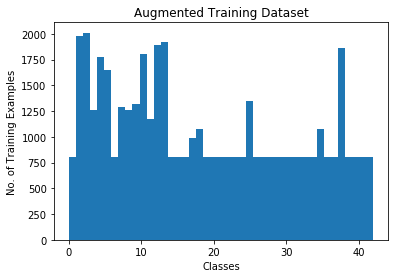

In [25]:
plt.hist(y_train, bins=n_classes)
plt.ylabel("No. of Training Examples")
plt.xlabel("Classes")
plt.title("Augmented Training Dataset")
plt.show()

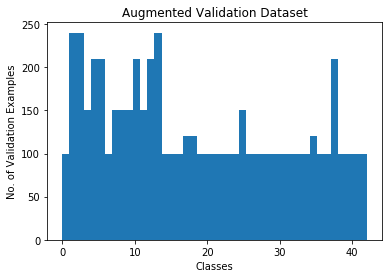

In [26]:
plt.hist(y_valid, bins=n_classes)
plt.ylabel("No. of Validation Examples")
plt.xlabel("Classes")
plt.title("Augmented Validation Dataset")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### 2.1 Pre-process the Dataset

#### 2.1.1 Pre-processing: Function to Convert to Grayscale
From Pierre Sermanet and Yann LeCun's paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks", using grayscale instead of colour images increased the performance of the neural network from 98.97% to 99.17%.

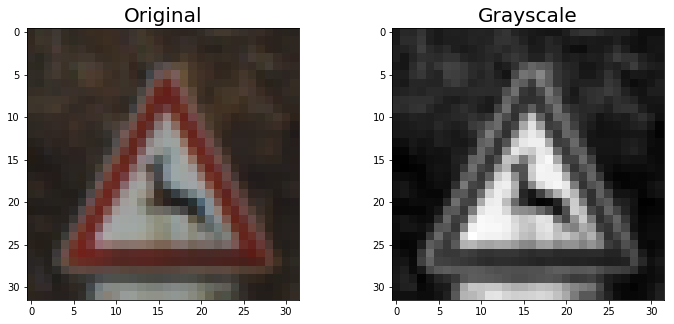

In [27]:
def grayscale(original_dataset):
    
    grayscale_dataset = np.sum(original_dataset/3,axis=3, keepdims=True)
    return grayscale_dataset

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.imshow(X_train[888])
ax1.set_title("Original", fontsize=20)

# Use np.squeeze() to reduce dimensionality from (32,32,1) to (32,32) for plot
ax2.imshow(np.squeeze(grayscale(X_train)[888]), cmap='gray')
ax2.set_title("Grayscale", fontsize=20)
plt.show()

#### 2.1.2 Pre-processing: Function to Normalize Images
The image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project.

Mean prior to normalization: 80.5
Mean after normalization: 1.2


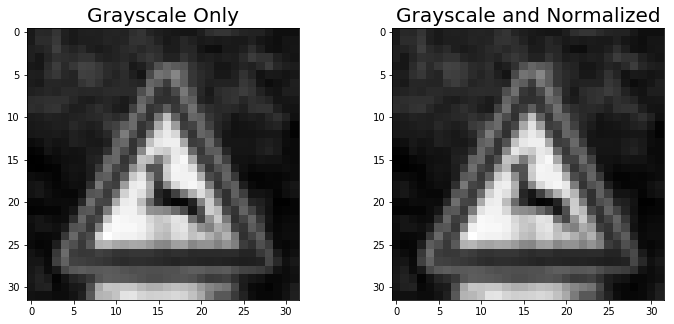

In [28]:
def normalize(grayscale_dataset):
    return (grayscale_dataset - 128)/128


print("Mean prior to normalization: {:.1f}".format(np.mean(X_train)))
print("Mean after normalization: {:.1f}".format(np.mean(normalize((X_train)))))

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.imshow(np.squeeze(grayscale(X_train)[888]), cmap='gray')
ax1.set_title("Grayscale Only", fontsize=20)
ax2.imshow(np.squeeze(normalize(grayscale(X_train))[888]), cmap='gray')
ax2.set_title("Grayscale and Normalized", fontsize=20)
plt.show()


#### 2.1.3 Pre-processing: Grayscale and Normalize All Training, Validation and Test Images

In [5]:
X_train = normalize(grayscale(X_train))
X_valid = normalize(grayscale(X_valid))
X_test = normalize(grayscale(X_test))

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(46480, 32, 32, 1)
(5630, 32, 32, 1)
(12630, 32, 32, 1)


### 2.2 Model Architecture
The LeNet-5 convolutional neural network architecture is used, with 2 convolutional layers and 3 fully connected layers. A slight modification to the original LeNet-5 architecture which I did was to add dropout to the fully connected layers, which significantly improved performance.

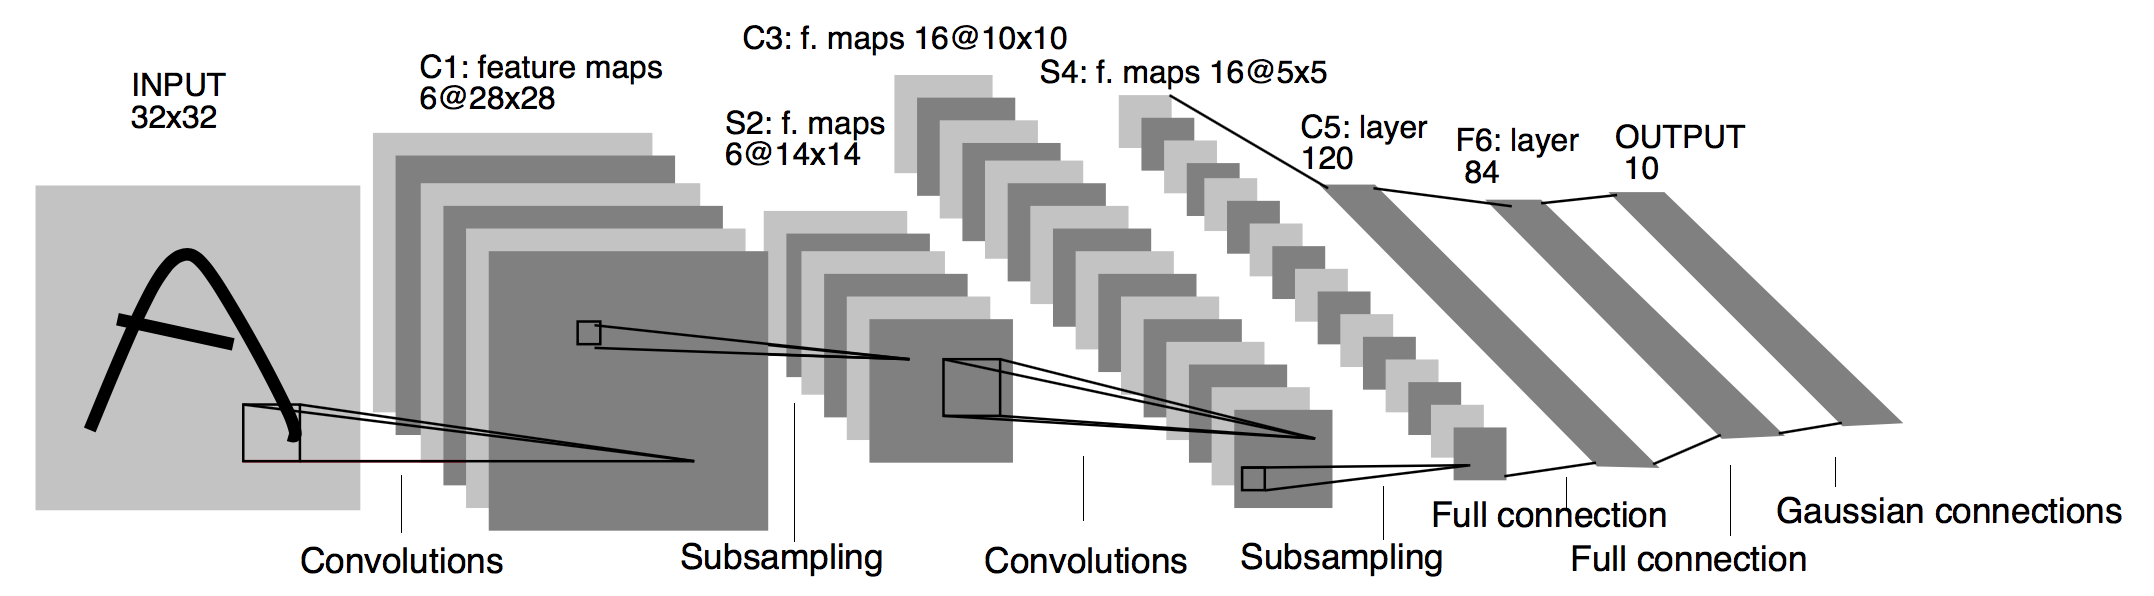

#### 2.2.1 Hyperparameters
Hyperparameters to be tweaked while fine-tuning the model.

In [6]:
EPOCHS = 30
BATCH_SIZE = 64
rate = 0.0016
dropout_prob = 0.5

#### 2.2.2 LeNet-5 Architecture

In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape = (5,5,1,6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides = [1,1,1,1], padding='VALID') + conv1_b
    
    # Activation
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize =  [1,2,2,1], strides = [1,2,2,1], padding='VALID')
    
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape = (5,5,6,16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides = [1,1,1,1], padding='VALID') + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize =  [1,2,2,1], strides = [1,2,2,1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape = (84,43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits
    
    

In [8]:
x = tf.placeholder(tf.float32, (None,32,32,1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y,43)


#### 2.2.3 Training Pipeline

In [9]:
logits = LeNet(x)

# Compare logits with ground truth labels to calculate cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# Averages the cross entropy across all training images
loss_operation = tf.reduce_mean(cross_entropy)

# Adam Optimizer, similar to stochastic gradient descent, to minimize loss function
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

# Backpropagation to update network and minimize training loss
training_operation = optimizer.minimize(loss_operation)

#### 2.2.4 Evaluation Pipeline

In [11]:
# Compare logits prediction to one-hot encoded ground truth labels
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y, 1))

# Calculate model's overall accuracy by averaging individual accuracies
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Average the accuracy of each batch to find the total accuracy of model
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


#### 2.2.5 Train the Model
Run the training data through the training pipeline to train the model.
Before each epoch, shuffle the training set.
After each epoch, measure the accuracy of the validation set.
Save the model after training.

In [12]:
with tf.Session() as sess:
    
    # Create tensorflow variables and initialize session
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        
        # Shuffle to ensure that training isn't biased by order of images
        X_train, y_train = shuffle(X_train, y_train)
        
        # Break training data into batches, and train model on each batch
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x : batch_x, y: batch_y, keep_prob: dropout_prob})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    # Save model once completely trained
    # So that it can be loaded and modified later, or evaluate model on test dataset
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved.")

Training...

EPOCH 1 ...
Validation Accuracy = 0.798

EPOCH 2 ...
Validation Accuracy = 0.887

EPOCH 3 ...
Validation Accuracy = 0.900

EPOCH 4 ...
Validation Accuracy = 0.909

EPOCH 5 ...
Validation Accuracy = 0.920

EPOCH 6 ...
Validation Accuracy = 0.937

EPOCH 7 ...
Validation Accuracy = 0.932

EPOCH 8 ...
Validation Accuracy = 0.945

EPOCH 9 ...
Validation Accuracy = 0.939

EPOCH 10 ...
Validation Accuracy = 0.940

EPOCH 11 ...
Validation Accuracy = 0.929

EPOCH 12 ...
Validation Accuracy = 0.933

EPOCH 13 ...
Validation Accuracy = 0.944

EPOCH 14 ...
Validation Accuracy = 0.929

EPOCH 15 ...
Validation Accuracy = 0.942

EPOCH 16 ...
Validation Accuracy = 0.938

EPOCH 17 ...
Validation Accuracy = 0.948

EPOCH 18 ...
Validation Accuracy = 0.950

EPOCH 19 ...
Validation Accuracy = 0.947

EPOCH 20 ...
Validation Accuracy = 0.946

EPOCH 21 ...
Validation Accuracy = 0.944

EPOCH 22 ...
Validation Accuracy = 0.944

EPOCH 23 ...
Validation Accuracy = 0.940

EPOCH 24 ...
Validation Accura

#### 2.2.6 Log of Model Changes

##### Test 1: Original LeNet-5 with Original Dataset
Best result is 90 - 92 %, using batch size of 64 and learning rate of 0.0007.

Batch = 128, Learning rate = 0.001
- 10 Epochs: 84 - 87 %
- 30 Epochs: 88 - 89 %
- 200 Epochs: 92 - 94 %

Batch = 128, Learning rate = 0.007
- 30 Epochs: 72 - 83 %

Batch = 128, Learning rate = 0.0007
- 30 Epochs: 88 - 91 %

Batch = 64, Learning rate = 0.0007
- 30 Epochs: 90 - 92 %

Batch = 256, Learning rate = 0.0007
- 30 Epochs: 85 - 87 %


##### Test 2: LeNet-5 with Normalized and Grayscaled Dataset
Best result is 91.0 - 93.5 %, using batch size of 128 and learning rate of 0.001.
From lecture, a change that affects 30 examples in the validation set is usually statistically significant and can be trusted. 
30/4410 validation examples = 0.7%.
As the improvement is > 0.7%, normalizing and grayscaling makes a significant difference.

Batch = 64, Learning rate = 0.0007
- 30 Epochs: 91.5 - 92.5 %

Batch = 128, Learning rate = 0.0007
- 30 Epochs: 89.5 - 92.5 %

Batch = 128, Learning rate = 0.001
- 30 Epochs: 91.0 - 93.5 %

Batch = 128, Learning rate = 0.0013
- 30 Epochs: 91.5 - 92.5 %

Batch = 64, Learning rate = 0.001
- 30 Epochs: 90.5 - 91.5 %

##### Test 3: LeNet-5 with Normalized, Grayscaled and Augmented (Translated) Dataset
Best result is 90.5 - 93.5%, using batch size of 64 and learning rate of 0.0013.
It seems like adding the augmented dataset decreases the performance of the neural network somewhat.

Batch = 128, Learning rate = 0.001
- 30 Epochs: 86.5 - 87.5 %

Batch = 64, Learning rate = 0.001
- 30 Epochs: 88.5 - 89.5 %

Batch = 64, Learning rate = 0.0007
- 30 Epochs: 84.5 - 88.0 %

Batch = 64, Learning rate = 0.0013
- 30 Epochs: 90.5 - 93.5 %

Batch = 128, Learning rate = 0.0013
- 30 Epochs: 86.0 - 88.5 %

Batch = 64, Learning rate = 0.0016
- 30 Epochs: 89.5 - 92.5 %

##### Test 4: LeNet-5 with Normalized, Grayscaled and Augmented (Brightness) Dataset
Best result is 89.0 - 91.5%, using batch size of 128 and learning rate of 0.0013.
I assumed that the translated images introduces black borders which was detrimental to the accuracy of the network, and used the images augmented by brightness adjustment (which do not introduce any black borders) to check this hypothesis. Looking at the results, this is most likely untrue.

Batch = 128, Learning rate = 0.001
- 30 Epochs: 88.0 - 90.5 %

Batch = 64, Learning rate = 0.001
- 30 Epochs: 89.0 - 89.5 %

Batch = 64, Learning rate = 0.0007
- 30 Epochs: 87.5 - 90.0 %

Batch = 64, Learning rate = 0.0013
- 30 Epochs: 89.5 - 91.0 %

Batch = 128, Learning rate = 0.0013
- 30 Epochs: 89.0 - 91.5 %

Batch = 64, Learning rate = 0.0016
- 30 Epochs: 87.0 - 91.5 %

##### Test 5: LeNet-5 with Normalized, Grayscaled and Augmented (Translated, Scaled, Rotated, Brightness) Dataset
Best result is 87.5 - 89.5%, using batch size of 64 and learning rate of 0.001. The validation accuracy drops sharply with the introduction of scaling, rotation and/or brightness and translation augmented datasets. We will need to relook at these augmented datasets.

Batch = 128, Learning rate = 0.001
- 30 Epochs:  82.0 - 85.5 %

Batch = 64, Learning rate = 0.001
- 30 Epochs:  87.5 - 89.5 %

Batch = 64, Learning rate = 0.0007
- 30 Epochs: 82.5 - 85.5 %

Batch = 64, Learning rate = 0.0013
- 30 Epochs:  85.5 - 89.0 %

Batch = 128, Learning rate = 0.0013
- 30 Epochs: 85.5 - 87.5 %

Batch = 64, Learning rate = 0.0016
- 30 Epochs: 85.0 - 88.0 %

##### Test 6: LeNet-5 with Normalized, Grayscaled and Augmented (Translated, Scaled, Rotated, Brightness) Dataset, and 50% Dropout
Best result is 90.0 - 91.0%, using batch size of 128 and learning rate of 0.0013.
Dropout decreased the range of values and increased the percentages of validation accuracies significantly.
Other than reducing overfitting, dropout makes the network more robust as it learns redundant representations, as though taking consensus over an ensemble of networks.

Batch = 128, Learning rate = 0.001
- 30 Epochs: 88.5 - 89.0 %

Batch = 64, Learning rate = 0.001
- 30 Epochs: 90.0 - 90.5 %

Batch = 64, Learning rate = 0.0007
- 30 Epochs: 88.0 - 88.5 %

Batch = 64, Learning rate = 0.0013
- 30 Epochs: 89.5 - 91.0 %

Batch = 128, Learning rate = 0.0013
- 30 Epochs: 90.0 - 91.0 %

Batch = 64, Learning rate = 0.0016
- 30 Epochs: 90.0 - 90.5 %

##### Test 7: LeNet-5 with Normalized, Grayscaled and Augmented (2 Pixel Translated, Scaled, Rotated) Dataset, and 50% Dropout
Re-looked at the marked difference in accuracy between Test 2 and Test 5. Why does the introduction of translation, scaling, rotating and brightness adjustment cause the validation accuracy to drop by 3-4%?
Decided to change the following:
- Decrease translation limit from +/-3 to +/-2 pixels
- Decrease scaling limit from +/-3 to +/-2 pixels
- Remove brightness, as algorithm was crude (simply adding a random number between 0 and 20 to the image). Checking the images revealed some unexpected patches of blue etc, because the max/min of 0 and 255 were not considered.

Batch = 128, Learning rate = 0.001
- 30 Epochs: 92.5 - 93.5 %

Batch = 64, Learning rate = 0.001
- 30 Epochs: 93.0 - 95.0 %

Batch = 64, Learning rate = 0.0007
- 30 Epochs: 94.0 - 94.5 %

Batch = 64, Learning rate = 0.0013
- 30 Epochs: 94.0 - 95.5 %

Batch = 128, Learning rate = 0.0013
- 30 Epochs: 93.0 - 94.0 %

Batch = 64, Learning rate = 0.0016
- 30 Epochs: 94.5 - 95.5 %

Best result is **94.5 - 95.5 %** validation accuracy, using batch size of 64 and learning rate of 0.0016.

#### 2.2.7 Evaluate the Model

Model should only be run on the test dataset **one time**, once we are completely done with training.

Otherwise, we would be using the test dataset to choose the best model, causing the test dataset to be an inaccurate reflection of how well the model would perform in the real world. 

This is because each time you make a decision about which classifier to use, or hyperparameter to tune, you give info to the classifier about the test set. Therefore, over time, the test data bleeds into the training data.


In [19]:
with tf.Session() as sess:
    saver.restore(sess, "lenet")
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob : 1.0})
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from lenet
Test Accuracy = 0.942


#### 2.2.8 Model Performance

The model has a validation accuracy of **94.5 - 95.5 %**, which exceeds the project requirement of 93.0%.

The model has a test accuracy of **94.2%**, which is only slightly lower than the validation accuracy. This shows that the trained model does not have much overfitting, and that the measures of introducing augmented data and dropout were effective in removing biasedness to the training and validation datasets.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### 3.1 Load and Output the Images

(5, 32, 32, 1)


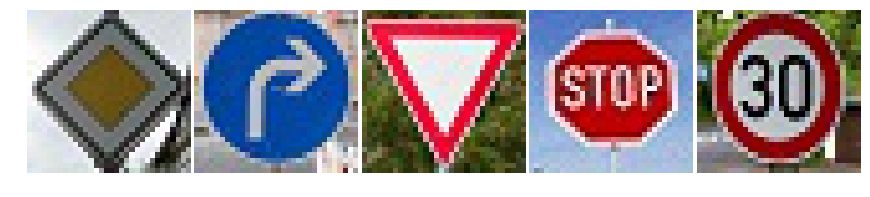

In [14]:
f, axs = plt.subplots(1, 5, figsize=(15,3))
f.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()

new_images = []

for num, img in enumerate(glob.glob('../new_images/*.jpg')):
    image = cv2.imread(img)
    new_images.append(image)
    axs[num].axis('off')
    axs[num].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Convert into numpy array for processing
new_images = np.array(new_images)
new_images = normalize(grayscale(new_images))
print(new_images.shape)

### 3.2 Predict the Sign Type for Each Image

In [36]:
new_classes = [12,33,13,14,1]

with tf.Session() as sess:
    saver.restore(sess, "lenet")
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: new_images, y: new_classes, keep_prob : 1.0})
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from lenet
Test Accuracy = 1.000


### 3.3 Analyze Performance

The model is 100% accurate for these 5 images. This is close to the model's performance of 94.2% on the test dataset.

### 3.4 Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [44]:
top_k = tf.nn.top_k(logits, k=5)

with tf.Session() as sess:
    saver.restore(sess, "lenet")
    my_top_k = sess.run(top_k, feed_dict={x: new_images, keep_prob: 1.0})
    
for i in range(5):
    print('\nImage', i+1, 'actual class: ', new_classes[i])
    print('Top 5 predicted classes: ', my_top_k[1][i])
    print('Softmax probabilities: ', my_top_k[0][i])

INFO:tensorflow:Restoring parameters from lenet

Image 1 actual class:  12
Top 5 predicted classes:  [12 40  7  9 32]
Softmax probabilities:  [ 28.49618912   5.36206818  -2.50945687  -6.25584984  -6.58933306]

Image 2 actual class:  33
Top 5 predicted classes:  [33 14 35 12  9]
Softmax probabilities:  [ 10.60202408  -1.73956537  -2.38802648  -3.20039368  -3.53802347]

Image 3 actual class:  13
Top 5 predicted classes:  [13 15 25  2 12]
Softmax probabilities:  [ 108.03132629   11.67026424   -5.59868765  -17.97875977  -26.88482857]

Image 4 actual class:  14
Top 5 predicted classes:  [14 34 38 13  1]
Softmax probabilities:  [ 38.59796524   0.11581142 -10.34112167 -11.08977985 -11.33390236]

Image 5 actual class:  1
Top 5 predicted classes:  [1 4 5 6 2]
Softmax probabilities:  [ 48.57098007  -0.64248371  -0.72158682  -1.49630368  -2.64485025]


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Miscellaneous Code: Visualize all 20km/h Signs (After Adding Augmented Images)

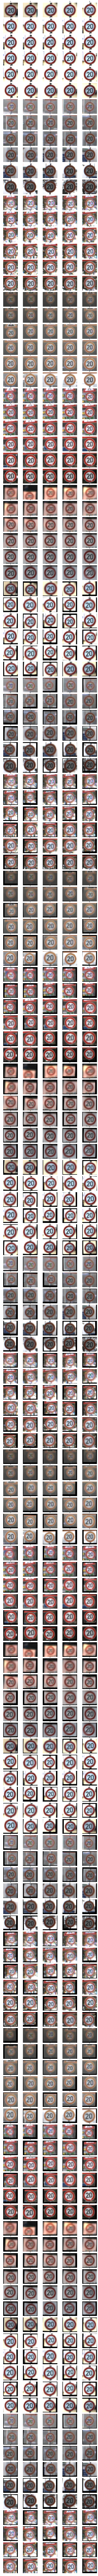

In [16]:
f, axs = plt.subplots(160, 5, figsize=(15,400))
f.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()
index_list = []
i=0
for photo in range(len(X_train)):
    if y_train[photo] == 0:
        index_list.append(i)
    i = i + 1

num=0
for i in index_list:
    axs[num].axis('off')
    axs[num].imshow(X_train[i])
    axs[num].set_title(y_train[i])
    num=num+1